In [8]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics

#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import scikitplot as skplt
import sklearn as sk
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [9]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [10]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [11]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_taylor2, load_taylor1a,load_misery, time_split
from common.calc_metrics import model_results

# Setup

## variables

In [12]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [13]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_test', train0_df['FEDFUNDS'], train0_df['ffef_tr'], train0_df.shape[0], 2  , None )
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('ffef_tr2_test', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], train0_df.shape[0], 2  , model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
train_df:  (203, 13)
test_df:  (51, 13)


name     r_sq  adj_r_sq      mse    rmse
0   ffef_tr_test  -0.9603   -0.9700  22.5094  4.7444
1   ffef_tr_test -39.2049  -40.0254  54.2610  7.3662
2  ffef_tr2_test   0.4449    0.4421   6.3743  2.5247
3  ffef_tr2_test -13.3523  -13.6452  19.3700  4.4011

# Load Data

# Stats Model - Taylor Index

In [14]:
taylor_df = load_taylor()
train_df, test_df = time_split(taylor_df)

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
train_df:  (203, 13)
test_df:  (51, 13)


In [15]:
X_train = train_df[['gap_inf', 'gap_ue']]
y_train = train_df['FEDFUNDS']


X_test = test_df[['gap_inf', 'gap_ue']]
y_test = test_df['FEDFUNDS']

In [16]:
# Initialize Imputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

# Initialize Transformer / OneHotEncoder
#cat_columns_lst = ['recession_flag','chair_name']
num_columns_lst = ['gap_inf', 'gap_ue']


#ohe_categories = list()
#for c in cat_columns_lst:
#    ohe_categories.append(list(X_train[c].unique()))
#    
#ohe = OneHotEncoder(categories=ohe_categories, drop='first',
#                   sparse_output=False, handle_unknown='ignore')

#transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')



numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
#categorical_transformer = Pipeline( steps=[('transformer',transformer)])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns_lst),
        #("cat", categorical_transformer, cat_columns_lst),
    ]
)

In [17]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
X_train_trf.columns = t_fit.get_feature_names_out()
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)


X_train_const = sm.add_constant(X_train_trf)

In [18]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FEDFUNDS   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     120.6
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           4.35e-35
Time:                        15:12:03   Log-Likelihood:                -455.48
No. Observations:                 203   AIC:                             917.0
Df Residuals:                     200   BIC:                             926.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.2076      0.209     20.102      0.000       3.795       4.620
num__gap_inf     1.0686      0.070     15.344      0.000       0.931       1.206
num__gap_ue      0.0974      0.107      0.914      0.362      -0.113       0.308
==============================================================================
Omnibus:                        0.499   Durbin-Watson:                   0.159
Prob(Omnibus):                  0.779   Jarque-Bera (JB):                0.246
Skew:                           0.045   Prob(JB):                        0.884
Kurtosis:                       3.145   Cond. No.                         4.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
train_pred = ols_result.predict(X_train_const)

t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)

In [20]:
model_stats_df = model_results('ols_train', y_train, train_pred_ols['mean'], X_train.shape[0], 2 , model_stats_df )

## Test

In [21]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (51, 3)


In [22]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

(51, 6)

In [23]:
model_stats_df = model_results('ols_test', y_test, test_pred_ols['mean'], X_test.shape[0], 2 , model_stats_df )

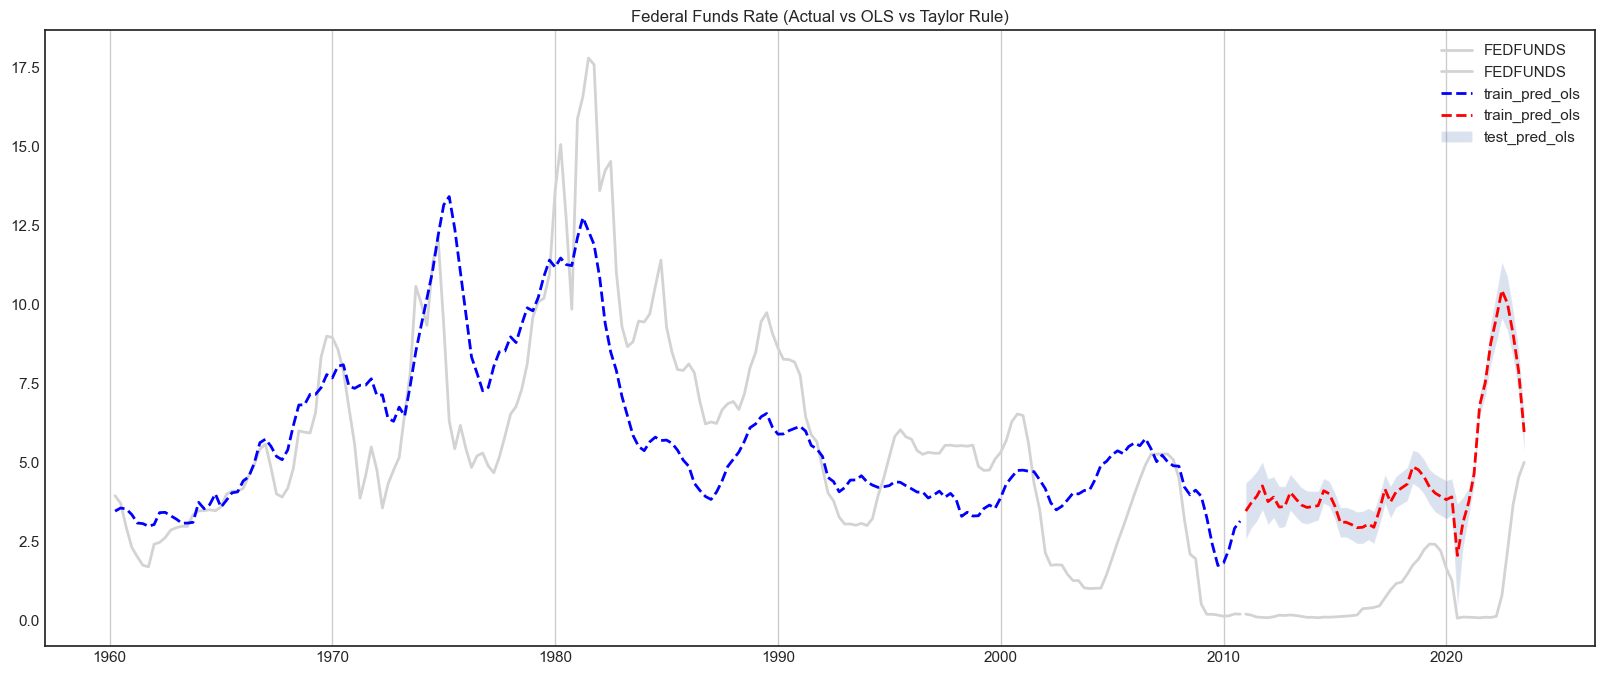

In [24]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_ols['mean'], color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_ols['mean'], color='red', linestyle='--', linewidth=2)
ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# LGBM

In [25]:
ltb_model = ltb.LGBMRegressor(verbose=-1).fit(X_train_trf, y_train)
train_pred_lgbm = ltb_model.predict(X_train_trf, pred_contrib=False, raw_score=False)

<Axes: >

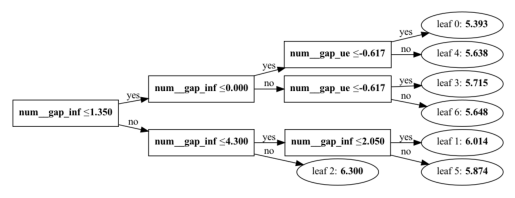

In [26]:
ltb.plot_tree(ltb_model)

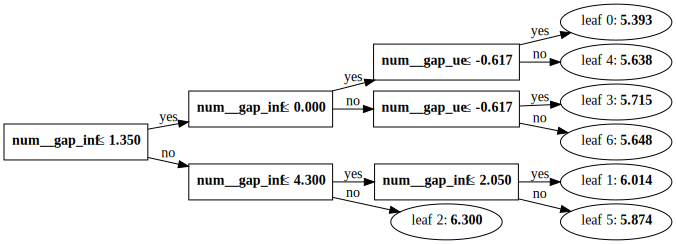

In [27]:
ltb.create_tree_digraph(ltb_model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

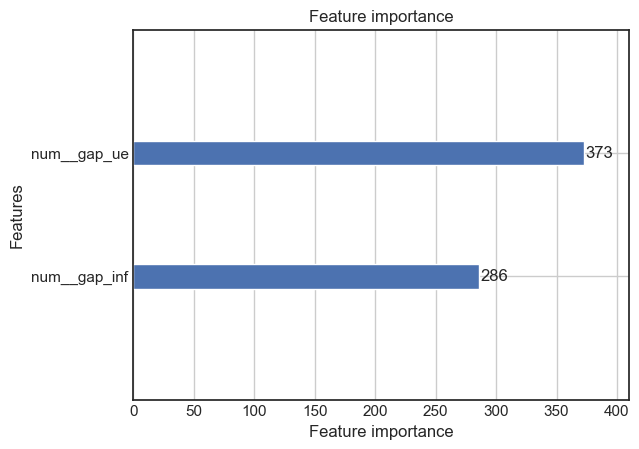

In [28]:
ltb.plot_importance(ltb_model)

In [29]:
model_stats_df = model_results('lgbm_train', y_train, train_pred_lgbm, X_train.shape[0], 2  , model_stats_df )

## Test

In [30]:
test_pred_lgbm = ltb_model.predict(X_test_trf, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

(51,)

In [31]:
model_stats_df = model_results('lgbm_test', y_test, test_pred_lgbm, X_train.shape[0], 2 , model_stats_df )

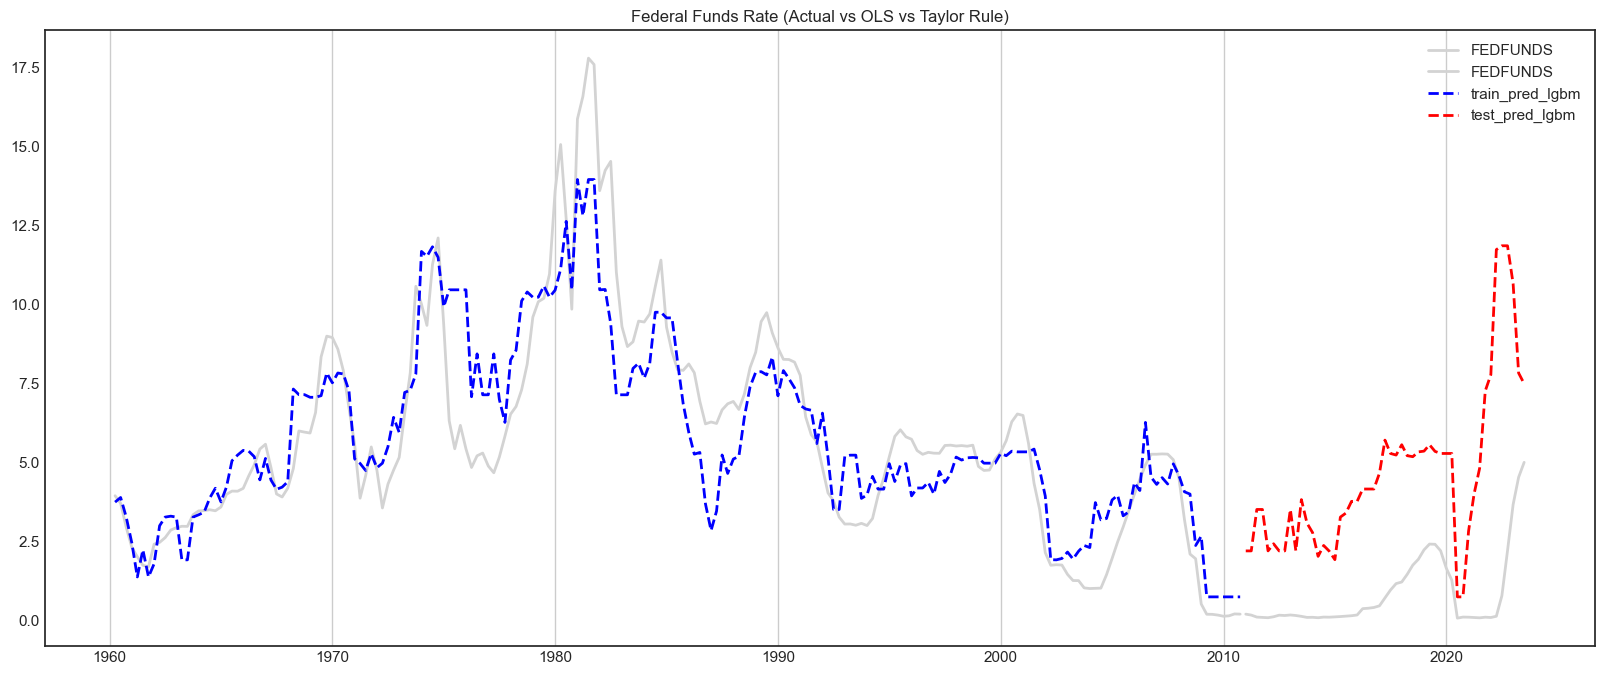

In [32]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# XGB

In [33]:
xgb_model = xgb.XGBRegressor(verbose=-1).fit(X_train_trf, y_train)
train_pred_xgb = xgb_model.predict(X_train_trf)
xgb_model.score(X_train_trf, y_train)

0.9976642729595905

In [34]:
model_stats_df = model_results('xgb_train', y_train, train_pred_xgb, X_train.shape[0], 2 , model_stats_df )

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

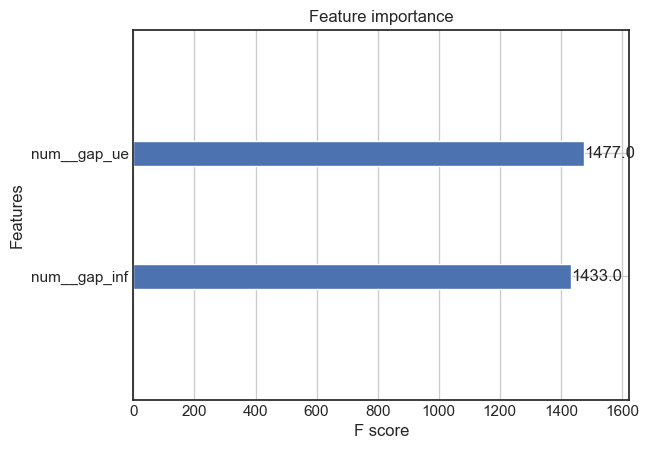

In [35]:
xgb.plot_importance(xgb_model)

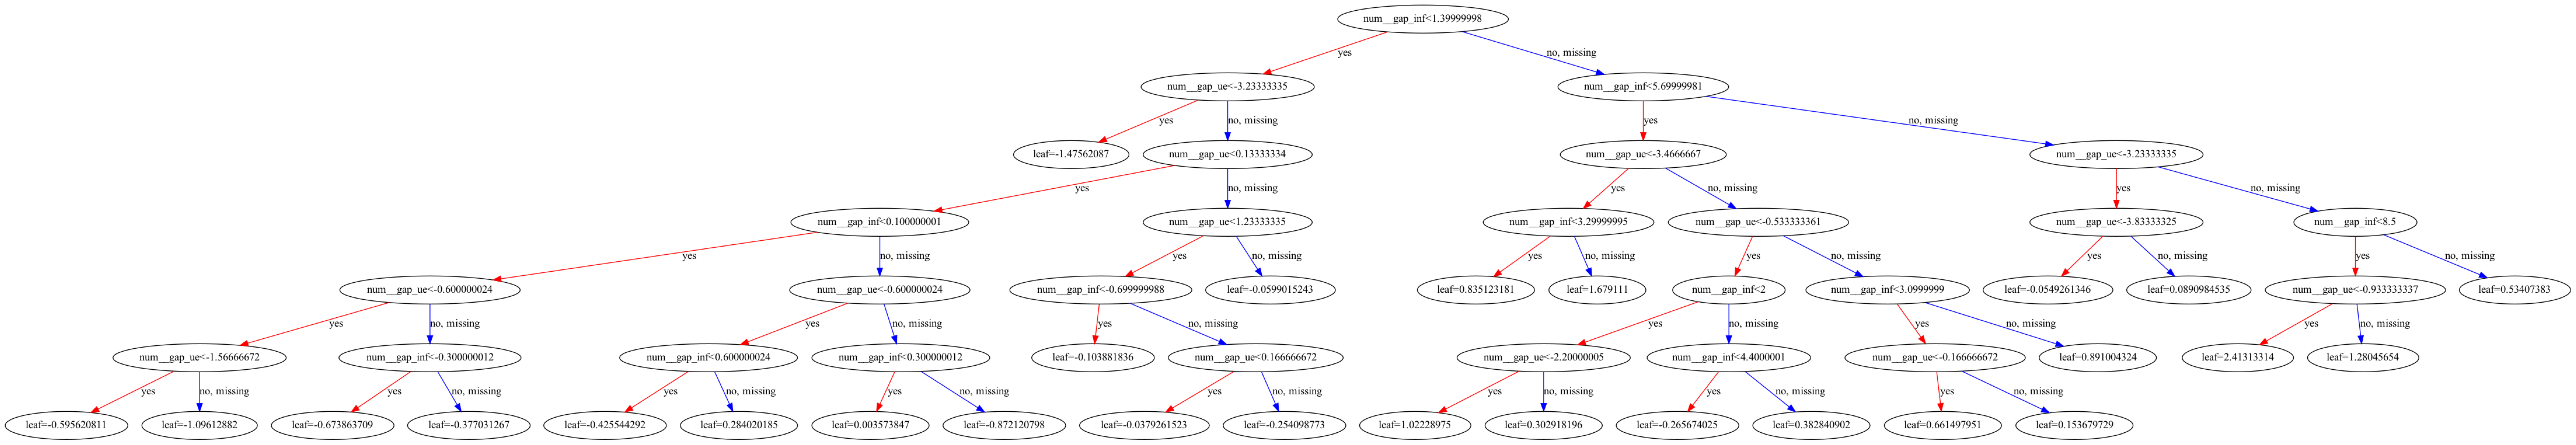

In [36]:
fig, ax = plt.subplots(figsize=(25,10))
#plt.figure(figsize=(12,12))
#xgb.plot_tree(xgb_model, ax=ax)
xgb.plot_tree(xgb_model, ax=ax,fontsize=10)

fig.set_size_inches(150, 100)
fig.savefig('tree.png')

fig.show()

## Test

In [37]:
test_pred_xgb = xgb_model.predict(X_test_trf)
test_pred_xgb.shape

(51,)

In [38]:
model_stats_df = model_results('xgb_test', y_test, test_pred_xgb, X_train.shape[0], 2 , model_stats_df )

# AdaBoostRegressor

In [39]:
ada_model = AdaBoostRegressor().fit(X_train_trf, y_train)
train_pred_ada = ada_model.predict(X_train_trf)

model_stats_df = model_results('ada_test', y_train, train_pred_ada, X_train_trf.shape[0], 2 , model_stats_df )

In [40]:
test_pred_ada = ada_model.predict(X_test_trf)
model_stats_df = model_results('ada_test', y_test, test_pred_ada, X_train_trf.shape[0], 2 , model_stats_df )

# tsa.SARIMAX

In [41]:
taylor2006_df = load_taylor()
#taylor2006_df = taylor2006_df.query('index < "2007-01-01"')
taylor2006_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)


FEDFUNDS    UNRATE     TB3MS      GDPC1        GDPPOT  GDPDEF_PC1  \
DATE                                                                            
1960-03-31  3.933333  5.133333  3.873333   3517.181   3255.290989         1.3   
1960-06-30  3.696667  5.233333  2.993333   3498.246   3288.916718         1.4   
1960-09-30  2.936667  5.533333  2.360000   3515.385   3321.957785         1.4   
1960-12-31  2.296667  6.266667  2.306667   3470.278   3353.814414         1.3   
1961-03-31  2.003333  6.800000  2.350000   3493.703   3385.151548         1.1   
...              ...       ...       ...        ...           ...         ...   
2022-06-30  0.770000  3.600000  1.076667  21708.160  20153.810000         7.7   
2022-09-30  2.190000  3.566667  2.663333  21851.134  20245.660000         7.3   
2022-12-31  3.653333  3.600000  4.040000  21989.981  20334.210000         6.4   
2023-03-31  4.516667  3.500000  4.626667  22112.329  20420.680000         5.3   
2023-06-30  4.990000  3.566667  5.073333  22225.350  20511.890000         3.5   

            gap_inf   gap_gdp    gap_ue    ffef_tr   ffef_tr2  recession_flag  \
DATE                                                                            
1960-03-31     -0.7  8.045057 -0.133333   6.972528   2.883333           False   
1960-06-30     -0.6  6.364688 -0.233333   6.282344   2.983333            True   
1960-09-30     -0.6  5.822687 -0.533333   6.011344   2.833333            True   
1960-12-31     -0.7  3.472571 -1.266667   4.686285   2.316667            True   
1961-03-31     -0.9  3.206694 -1.800000   4.253347   1.750000           False   
...             ...       ...       ...        ...        ...             ...   
2022-06-30      5.7  7.712437  1.400000  16.406219  13.250000           False   
2022-09-30      5.3  7.929966  1.433333  15.914983  12.666667           False   
2022-12-31      4.4  8.142785  1.400000  14.671392  11.300000           False   
2023-03-31      3.3  8.283999  1.500000  13.092000   9.700000           False   
2023-06-30      1.5  8.353496  1.433333  10.426748   6.966667           False   

           chair_name  
DATE                   
1960-03-31     Martin  
1960-06-30     Martin  
1960-09-30     Martin  
1960-12-31     Martin  
1961-03-31     Martin  
...               ...  
2022-06-30     Powell  
2022-09-30     Powell  
2022-12-31     Powell  
2023-03-31     Powell  
2023-06-30     Powell  

[254 rows x 13 columns]

In [42]:
train2006_df, test2006_df = time_split(taylor2006_df)

train_df:  (203, 13)
test_df:  (51, 13)


In [43]:
X_train = train2006_df[['gap_inf', 'gap_ue']]
X_train_trf = t_fit.transform(X_train)


y_train = train2006_df['FEDFUNDS']

In [44]:
model = sm.tsa.SARIMAX(y_train, exog=X_train_trf)
result_model = model.fit(disp=False)

result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  203
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -246.798
Date:                Mon, 20 Nov 2023   AIC                            501.596
Time:                        15:12:12   BIC                            514.849
Sample:                    03-31-1960   HQIC                           506.958
                         - 09-30-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6122      0.101      6.062      0.000       0.414       0.810
x2             1.2476      0.137      9.075      0.000       0.978       1.517
ar.L1          0.9918      0.007    144.124      0.000       0.978       1.005
sigma2         0.6527      0.033     19.910      0.000       0.588       0.717
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):               839.88
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             1.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
train_result = result_model.get_prediction(start=-len(X_train_trf), dynamic=True)

In [46]:
train_pred_SARIM = train_result.summary_frame()
train_pred_SARIM

FEDFUNDS        mean   mean_se  mean_ci_lower  mean_ci_upper
1960-03-31 -0.594875  6.337657     -13.016454      11.826704
1960-06-30 -0.658421  6.337657     -13.080000      11.763159
1960-09-30 -1.032711  6.337657     -13.454290      11.388869
1960-12-31 -2.008859  6.337657     -14.430439      10.412720
1961-03-31 -2.796699  6.337657     -15.218279       9.624880
...              ...       ...            ...            ...
2009-09-30 -6.943837  6.337657     -19.365417       5.477742
2009-12-31 -7.256910  6.337657     -19.678489       5.164670
2010-03-31 -6.887276  6.337657     -19.308855       5.534304
2010-06-30 -6.270443  6.337657     -18.692022       6.151136
2010-09-30 -5.940069  6.337657     -18.361648       6.481511

[203 rows x 4 columns]

## Test

In [47]:
X_test = test2006_df[['gap_inf', 'gap_ue']]
X_test_trf = t_fit.transform(X_test)

y_test = train2006_df['FEDFUNDS']

In [48]:
s_idx = len(X_train_trf)
e_idx = s_idx + len(X_test_trf) - 1

test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=X_test_trf, dynamic=True)

In [49]:
test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

(51, 4)

In [50]:
predict_ci = test_result.conf_int(alpha=0.5)
predict_ci.head()

lower FEDFUNDS  upper FEDFUNDS
2010-12-31       -0.266156        0.823656
2011-03-31        0.166364        1.701318
2011-06-30        0.029372        1.901666
2011-09-30        0.106986        2.260173
2011-12-31        0.087778        2.485395

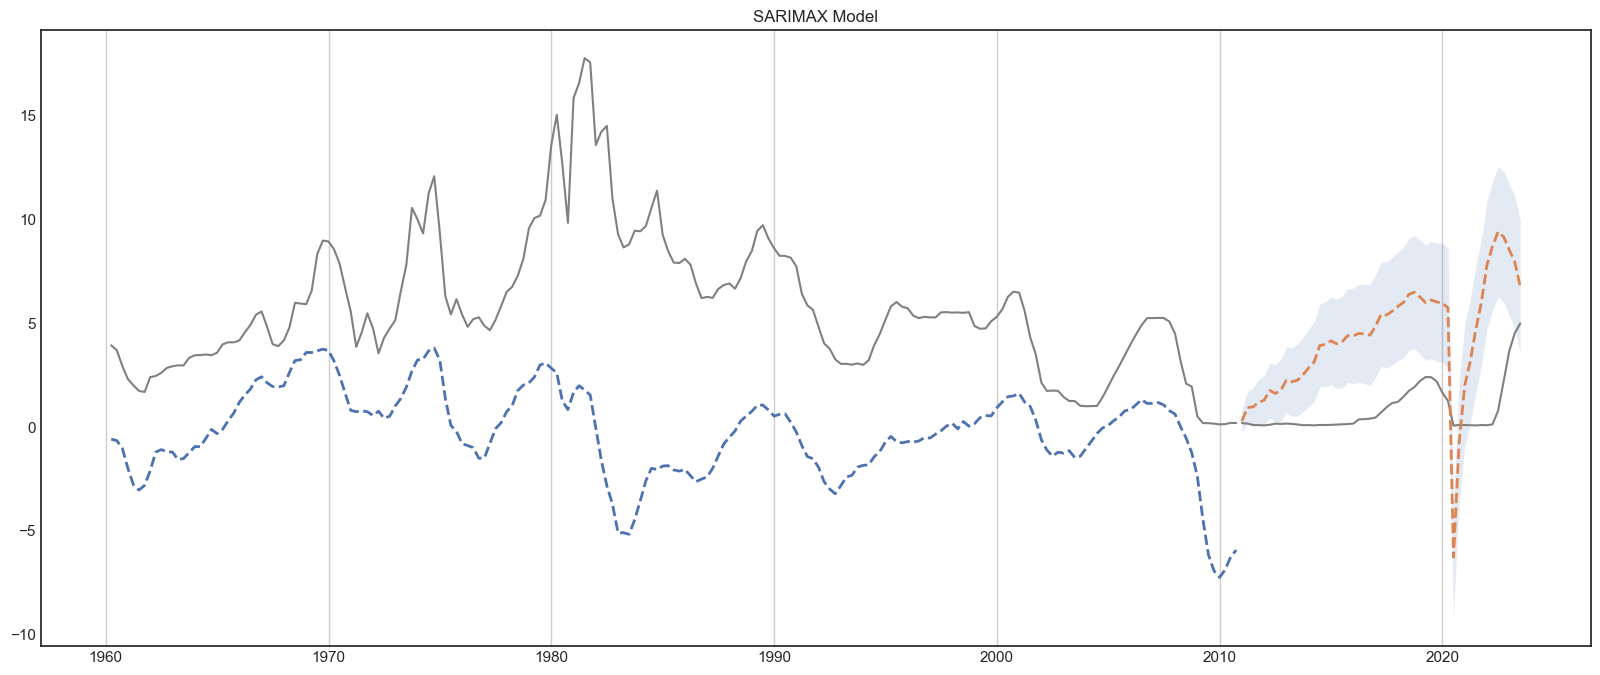

In [51]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train2006_df.index, train2006_df['FEDFUNDS'], 'gray')
ax.plot(test2006_df.index, test2006_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, predict_ci['lower FEDFUNDS'], predict_ci['upper FEDFUNDS'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [52]:
print('SARIMAX RMSE(Train):' , statsmodels.tools.eval_measures.rmse(train2006_df['FEDFUNDS'], train_pred_SARIM['mean']))
print('SARIMAX RMSE(Test):' , statsmodels.tools.eval_measures.rmse(test2006_df['FEDFUNDS'], test_pred_SARIM['mean']))

SARIMAX RMSE(Train): 6.842689444591951
SARIMAX RMSE(Test): 4.151255057294269


In [53]:
print('SARIMAX R-Squard(Train):' , r2_score(train2006_df['FEDFUNDS'], train_pred_SARIM['mean']))
print('SARIMAX R-Squard(Test):' , r2_score(test2006_df['FEDFUNDS'], test_pred_SARIM['mean']))

SARIMAX R-Squard(Train): -3.077648413623506
SARIMAX R-Squard(Test): -11.768816082127307


In [54]:
model_stats_df = model_results('SARIMAX_train',train2006_df['FEDFUNDS'], train_pred_SARIM['mean'], X_train.shape[0],2 , model_stats_df )
model_stats_df = model_results('SARIMAX_test', test2006_df['FEDFUNDS'], test_pred_SARIM['mean'], X_test.shape[0], 2 , model_stats_df )
model_stats_df

name     r_sq  adj_r_sq      mse    rmse
0    ffef_tr_test  -0.9603   -0.9700  22.5094  4.7444
1    ffef_tr_test -39.2049  -40.0254  54.2610  7.3662
2   ffef_tr2_test   0.4449    0.4421   6.3743  2.5247
3   ffef_tr2_test -13.3523  -13.6452  19.3700  4.4011
4       ols_train   0.5467    0.5444   5.2051  2.2815
5        ols_test -11.8922  -12.1553  17.3994  4.1713
6      lgbm_train   0.7790    0.7779   2.5372  1.5929
7       lgbm_test -13.1493  -13.2197  19.0961  4.3699
8       xgb_train   0.9977    0.9977   0.0268  0.1638
9        xgb_test -11.7474  -11.8109  17.2041  4.1478
10       ada_test   0.7767    0.7756   2.5635  1.6011
11       ada_test -11.3207  -11.3820  16.6282  4.0778
12  SARIMAX_train  -3.0776   -3.0979  46.8224  6.8427
13   SARIMAX_test -11.7688  -12.0294  17.2329  4.1513